# Final Project
This notebook is the final project for CSCA5622 in the fall of 2023, as submitted by David Murphy dfm794@gmail.com
github repo can be found here [https://github.com/dfm794/final_project_csca5622]

## Problem Description
The problem of correctly identifying emotion in a short audio recording, in the supervised learning setting, is fairly well solved for deep learing methods using LSTM or Transformer architectures, provided sufficient data is available.

We aim to understand if this problem is solvable in a small data regime, with one of the methods taught in this class. We chose the SVM architecture and the RAVDESS dataset and attempt to classify the emotion in speech data.

### About the dataset
The RAVDESS dataset (retreived originally from here: [https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data] and decribed in [https://doi.org/10.1371/journal.pone.0196391](a PLoS ONE paper) contains speech and song audio and video data.

We are working with a subset of that dataset that contains speech expressed with different emotions. The dataset is small by modern standards, containing speech from just 24 actors. There are 60 trials per actor covering 8 emotions at two intensities on two phrases. The total dataset consists of 1440 files, one per trial.

## Approach
The steps in our approach is as follows
- Extract information from the dataset's files into a panda's dataframe
- Examine a few random samples from the dataset by viewing speech waveform, listening to it, constructing mel spectrograms for visualization and converting the melspectrograms to mel-frequency cepstral coefficients (mfcc) data for use as input to the models
- Build a binary SVM classifer for two arbitrary emotions on data and labels extracted from the dataset
- Examine the effect of different kernels and normalization schemes to determine the best classifer model to use on the remaining data
- Using the information learned, attempt to build a multi-class SVM for the full dataset, and build a confusion matrix on the test data
- Summarize results


#### Dataset Citation
"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

In [1]:
#imports for the notebook are collected here. See the requirements file in the repository to ensure compatible versions
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import librosa
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from IPython.display import Audio


In [2]:
#import basic dataset into a pandas frame for later processing
#dataset is the directory name containing the data organized in directories, one per actor
#dataset_path is the path to the dataset directory. replace this as appropriate for your runtime and directory structure
dataset = "audio_speech_actors_01-24"
dataset_path = "./archive"

#dictionaries for mapping file name components to meaningful text strings, or to map strings to integer labels for later use
emotion_mapping = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised',
}

rev_emotion_mapping = {
    'neutral': 1,
    'calm': 2,
    'happy': 3,
    'sad': 4,
    'angry': 5,
    'fearful': 6,
    'disgust': 7,
    'surprised': 8,
}
intensity_mapping = {
    '01':'normal',
    '02':'strong',
}

#labels to be used for the columns when creating the Pandas data table
column_labels = ["label", "path", "id", "intensity", "sex", "phrase"]

#extract information from the directory and files names, in which the information describing the properties of the dataset are encoded
#the data directory contains recordings from 24 actors. Each actor's recordings are under their own directory of the form Actor_id,
#where id is an integer. Even ids are female actors, odd ids are male.
#each file in an actor's directory is an audio file. The file names are a series of two digits, separated by '-' and ending in .wav
#for example 03-01-06-01-02-01-12.wav
#the first two numbers 03-01 are the same for all files as this indicates audio data and speech data respectively.
#the following numbers, in order, represent emotion, intensity, phrase, trial and actor.
#we extract the actor id from the containing directory, and the emotion, intensity, sex and phrase from the file name.
#we then store this data, along with the path to audio file in a pandas dataframe. The emotion serves as the label for 
#classification.

#empty list for temporary store of datatable
data_table = []
#loop over all items in the dataset directory
for actor in os.listdir(os.path.join(dataset_path, dataset)):
    #skip over any files/directoies that are not of the form 'Actor_id'
    if actor.split('_')[0] != 'Actor':
        continue
    #retrieve the actor id
    ident = actor.split('_')[1]
    #retieve all audio files names for this actor
    actor_data_files = os.listdir(os.path.join(dataset_path, dataset, actor))
    #extract sex of the actor
    sex = 'female' if int(actor.split('_')[1])%2 == 0 else 'male'
    #print(actor_data_files)
    #print(actor, sex)

    #loop over all audio files for this actor
    for data_file in actor_data_files:
        #extract the numbers from the file name and map them to data keys
        data_keys = data_file.split('.')[0].split('-')
        emotion = emotion_mapping[data_keys[2]]
        intensity = intensity_mapping[data_keys[3]]
        phrase = data_keys[4]
        #print(f'{ident}, sex {sex}, emotion: {emotion}, intensity {intensity}')
        
        #create a row for the table as
        #emotion, path_to_file, ident, intensity, phrase, sex -- note the emotion is the 'label'
        data_entry = [emotion, os.path.join(dataset_path, dataset, actor, data_file), ident, intensity, sex, phrase]
        #print(data_entry)
        #add the row to the data_table
        data_table.append(data_entry)
        
#create the dataframe from the data_table
df = pd.DataFrame(data=data_table, columns=column_labels)

#check basic info
df.info()
df.head()
#df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1440 non-null   object
 1   path       1440 non-null   object
 2   id         1440 non-null   object
 3   intensity  1440 non-null   object
 4   sex        1440 non-null   object
 5   phrase     1440 non-null   object
dtypes: object(6)
memory usage: 67.6+ KB


,label,path,id,intensity,sex,phrase
0,angry,./archive/audio_speech_actors_01-24/Actor_16/0...,16,normal,female,02
1,fearful,./archive/audio_speech_actors_01-24/Actor_16/0...,16,normal,female,02
2,fearful,./archive/audio_speech_actors_01-24/Actor_16/0...,16,strong,female,01
3,angry,./archive/audio_speech_actors_01-24/Actor_16/0...,16,strong,female,01
4,disgust,./archive/audio_speech_actors_01-24/Actor_16/0...,16,normal,female,01


In [3]:
# Here we examine several audio samples by choosing an arbitrary data entry and
# Attempt to open a file and play the audio
audio_sample = 27
audio_segment, sampling_rate = librosa.load(df.path[audio_sample])

In [4]:
Audio(df.path[audio_sample])

In [5]:
print(sampling_rate)

22050


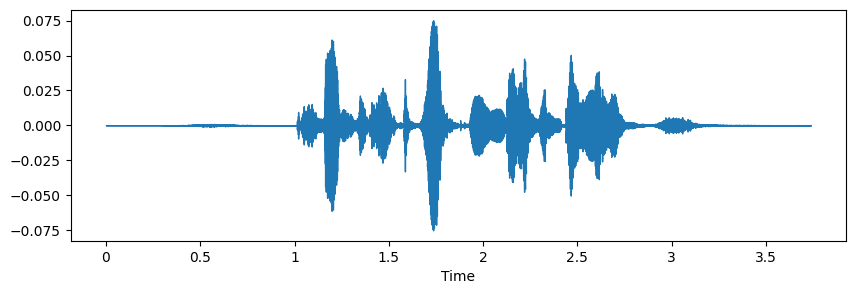

In [6]:
plt.figure(figsize=(10,3))
librosa.display.waveshow(audio_segment, sr=sampling_rate)

(128, 161)


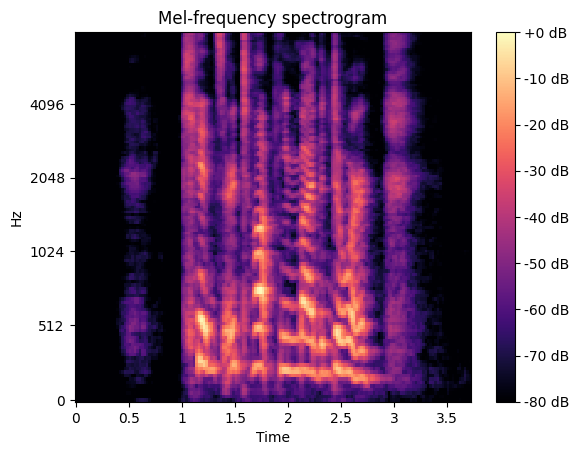

In [7]:
#examine the mel spectrogram of the audio data
fig,ax = plt.subplots()
melspec = librosa.feature.melspectrogram(y=audio_segment, sr=sampling_rate, n_mels=128, fmax=8000)
melspec_db = librosa.power_to_db(melspec, ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
print(melspec.shape)

(20, 161)


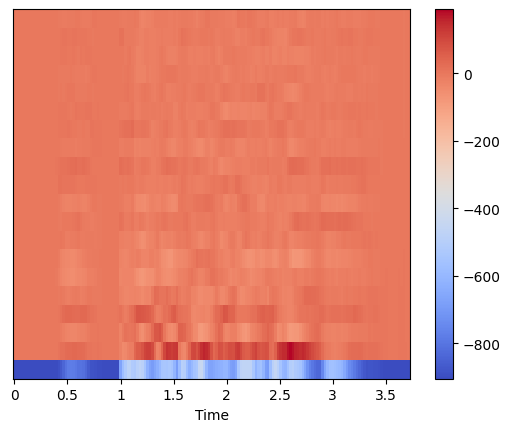

In [8]:
mfcc = librosa.feature.mfcc(S=melspec_db)
fig,ax = plt.subplots()
img2 = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img2, ax=ax)

print(mfcc.shape)

After examining several files, we consistently see that the ~first second and last second are silent. This adds no useful data.
We've decided to arbitrarily clip the audio so that it starts at approximately one second and lasts ~2.2 seconds.

The net effect of this is not loss in useful data, but a decrease in the feature data from a matrix of 20x161, to 20x94
Below were repeat the visualizations to show the difference.

In [9]:
#use a start and stop sample index to limit the length of the sound sample per above 

Start_Sample_Index = 22000
Stop_Sample_Index = 70000

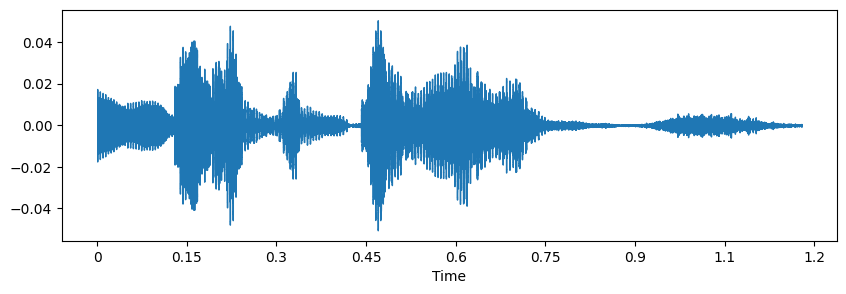

In [10]:
audio_segment=audio_segment[Start_Sample_Index:Stop_Sample_Index]
plt.figure(figsize=(10,3))
librosa.display.waveshow(audio_segment[Start_Sample_Index:Stop_Sample_Index], sr=sampling_rate)

(128, 94)


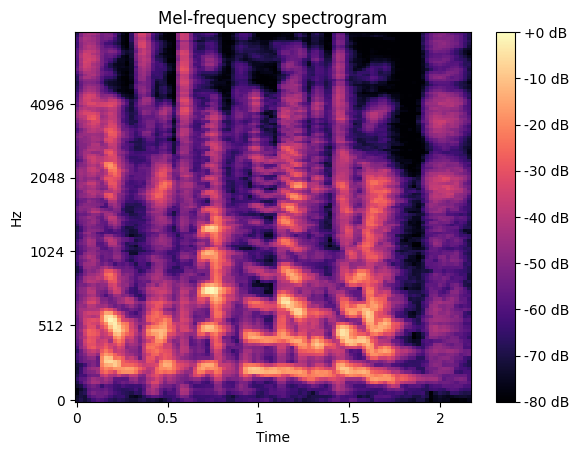

In [11]:
#let's see the spectrogram
fig,ax = plt.subplots()
melspec = librosa.feature.melspectrogram(y=audio_segment, sr=sampling_rate, n_mels=128, fmax=8000)
melspec_db = librosa.power_to_db(melspec, ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
print(melspec.shape)

(20, 94)


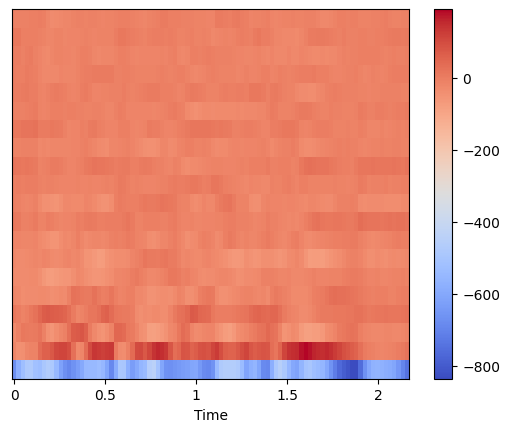

In [12]:
mfcc = librosa.feature.mfcc(S=melspec_db)
fig,ax = plt.subplots()
img2 = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img2, ax=ax)

print(mfcc.shape)

In [13]:
#helper function to extract mfcc from audio sample
def extract_mfcc(sample, sample_rate, n_mels=128, fmax=8000):
    melspec = librosa.feature.melspectrogram(y=sample, sr=sample_rate, n_mels=n_mels, fmax=fmax)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    mfcc = librosa.feature.mfcc(S=melspec_db)
    return(mfcc)
    
#function to extract data from the raw data frame
#data is returned as a tuple of numpy arrays (data, labels)
#The function can extract data three ways depending on arguments.
#if called with two 'emotions', then the returned data is a list of the flattened mfccs for the two emotions
#and label values of {1, -1}, 1 for the first emotion and -1 for the second.
#called with more than two labels and binary_class==True, then the same type of data is returned
#where the first emotion is labeled 1, and the remainder all labeled as -1.
#if binary_class is false, then a multiclass classification is assumed, the labels are taken from the 
#reverse mapping of emotions to integers.
#
#The data can be returned as is, or normalized. if normalization='none', no normalization is performed.
#if normalization='coef', then normalization is per mfcc coeficient, if normalization is 'norm', then 
#the entire sample is normalized.

def extract_data(data_frame, labels=['happy', 'angry'], binary_class=True, start_sample=22000, end_sample=70000,
                 normalization='none', flatten=True):
    X = []
    y = []
    if len(labels) < 2:
        print(f'Illegal values for extract_data, missing data_frame or too few labels')
        return [], []
    #binary classification of two emotions
    if len(labels) == 2:
        #extract a dataframe of only the two emotions of interest
        sub_frame = data_frame[(data_frame.label == labels[0]) | (data_frame.label == labels[1])]
        #iterate over each row, extract path and create mfcc
        for index, row in sub_frame.iterrows():
            audio_segment, sampling_rate = librosa.load(row.path)
            audio_segment = audio_segment[start_sample:end_sample]
            mfcc = extract_mfcc(audio_segment, sampling_rate)
            #ensure correct shapes - a few examples yield incorrect column count. We could pad, but chose to skip these examples
            if mfcc.shape[1] != 94:
                print(f'file {row.path} yeilds unexpected mfcc size, skipping')
                continue
            #normalize if required
            if normalization=='coef':
                mfcc = normalize(mfcc, axis=1, norm='l1')
            X.append(mfcc)
            y.append(1 if row.label==labels[0] else -1)
    elif binary_class == True:
        print("binary_class with more than two input classes not yet implemented")
        return [], []
    else:
        #data generation for multiclass setting
        #loop over dataframe and extract mfcc
        for index, row in data_frame.iterrows():
            #if encountering a label in the dataframe that is not requested, skip it
            if(row.label not in labels):
                print(f'skipping {row.label}')
                continue
            audio_segment, sampling_rate = librosa.load(row.path)
            audio_segment = audio_segment[start_sample:end_sample]
            mfcc = extract_mfcc(audio_segment, sampling_rate)
            #ensure correct shapes - a few examples yield incorrect column count. We could pad, but chose to skip these examples
            if mfcc.shape[1] != 94:
                print(f'file {row.path} yeilds unexpected mfcc size, skipping')
                continue
            #normalize if required
            if normalization=='coef':
                mfcc = normalize(mfcc, axis=1, norm='l1')
            X.append(mfcc)
            y.append(rev_emotion_mapping[row.label])
    #convert to numpy arrays
    X = np.array(X)
    #flatten data if requested and normalize of appropriate
    if flatten==True:
        X = X.reshape(X.shape[0], -1)
        if normalization=='norm':
            X = normalize(X, axis=1, norm='l1')
    y = np.array(y)
    return X, y

In [14]:
#Validate we can extract data
#extact it for two arbitrary motions and well examine how different SVM kernels behave with this data
X_h_v_a, y_h_v_a = extract_data(df, labels=['happy', 'angry'])
print(X_h_v_a.shape, y_h_v_a.shape)
print(X_h_v_a)
print(y_h_v_a)

file ./archive/audio_speech_actors_01-24/Actor_11/03-01-03-01-01-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_13/03-01-03-01-02-01-13.wav yeilds unexpected mfcc size, skipping
(382, 1880) (382,)
[[-4.7986746e+02 -3.9332434e+02 -3.9822916e+02 ... -4.2179012e+00
  -3.6757727e+00 -1.9968486e+00]
 [-6.9646643e+02 -5.6671692e+02 -5.3142053e+02 ... -1.1323339e+00
  -2.1136627e+00 -1.3832281e+00]
 [-7.4966998e+02 -5.3381989e+02 -4.4396112e+02 ...  6.9966596e-01
   3.7706390e-01  1.4357575e+00]
 ...
 [-7.0436462e+02 -5.9798364e+02 -5.4202118e+02 ...  3.7586811e+00
   4.9071932e-01 -1.5867162e+00]
 [-8.5985028e+02 -8.0708429e+02 -6.4276343e+02 ... -3.2285426e+00
  -2.9709880e+00  1.0770167e+00]
 [-7.7198517e+02 -7.1500873e+02 -5.6592023e+02 ...  5.0134163e+00
   3.6233456e+00  1.4297603e+00]]
[-1 -1  1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1
 -1 -1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1  1 -1 -1 -1
 -1  1  1

#### Quick test of SVM models
Examine four kernels with arbitrary C and gamma on this data and see if we learn anything.
(note, gamma means nothing for linear, but leave for cut/paste ease)

In [15]:
#first linear
svm_model = SVC(C=7.5, gamma=2.0, kernel='linear', random_state=42)
scores = cross_val_score(svm_model, X_h_v_a, y_h_v_a, cv=5)
print(scores)

[0.75324675 0.7012987  0.81578947 0.81578947 0.78947368]


In [16]:
#second poly
svm_model = SVC(C=7.5, gamma=2.0, kernel='poly', random_state=42)
scores = cross_val_score(svm_model, X_h_v_a, y_h_v_a, cv=5)
print(scores)

[0.75324675 0.71428571 0.81578947 0.85526316 0.81578947]


In [17]:
#third radial bias function
svm_model = SVC(C=7.5, gamma=2.0, kernel='rbf', random_state=42)
scores = cross_val_score(svm_model, X_h_v_a, y_h_v_a, cv=5)
print(scores)

[0.50649351 0.50649351 0.5        0.5        0.5       ]


In [18]:
#fourth sigmoid
svm_model = SVC(C=7.5, gamma=2.0, kernel='sigmoid', random_state=42)
scores = cross_val_score(svm_model, X_h_v_a, y_h_v_a, cv=5)
print(scores)

[0.50649351 0.50649351 0.5        0.5        0.5       ]


#### Results - Quick test of SVM models
The simple quick tests above on the two arbitrary emotions, happy and angry, on raw data show that learning does take place
Here it seems that the linear and poly kernels are able to achieve somewhere in the neighborhood of 77% average accuracy on cross-validation.

With this promising start, let's exam what grid search over C and gamma for the various kernels can achieve.

In [19]:
#The following class and function are taken from the Week 6 assignment and borrowed here for visualization of results of
#the grid searches.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
        
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

In [20]:
#simple helper function since we'll be calling this template over and over again
#for the rest of this notebook
def grid_search(kernel, X, y):
    vals = np.array([2.0**-5, 2.0**-4, 2.0**-3, 2.0**-2, 2.0**-1, 2.0**0, 2.0**1, 2.0**2, 2.0**3, 2.0**4, 2.0**5, 2.0**6, 2.0**7, 2.0**8])
    c_vals = vals
    g_vals = vals
    #params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C':c_vals, 'gamma':g_vals}
    params = {'kernel':[kernel], 'C':c_vals, 'gamma':g_vals}

    grid = GridSearchCV(SVC(random_state=42), params, cv=5 )
    grid.fit(X, y)
    return grid

#### Grid Search over 'C' and 'gamma' for linear, poly, radial bias function and sigmoid kernels
Having seen that an SVM model is learnable, perform grid searches over 'C' and 'gamma' to determine the best parameters for each kernel and examine the resulting accuracies

{'C': 0.03125, 'gamma': 0.03125, 'kernel': 'linear'}
0.7751196172248804


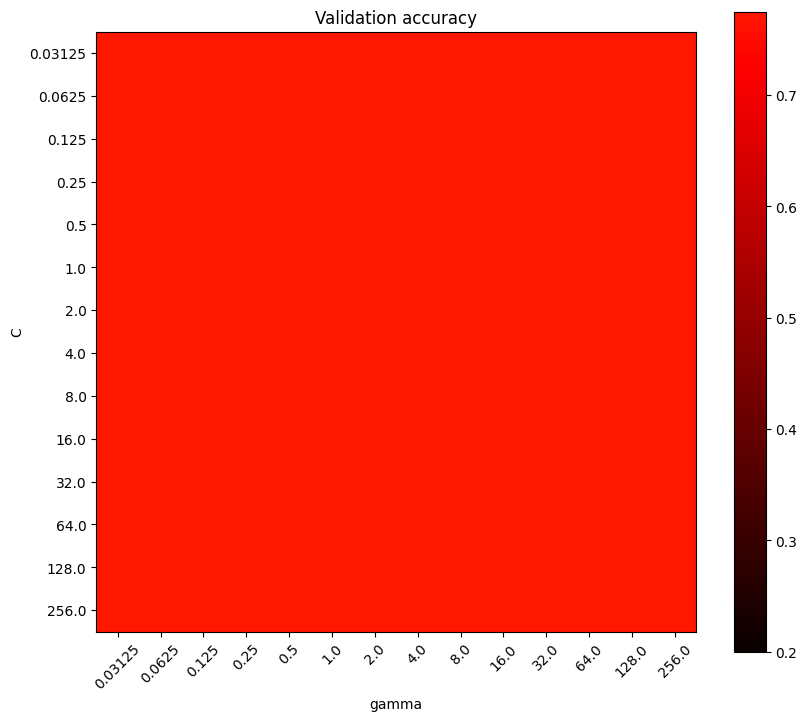

In [21]:
linear_grid = grid_search('linear', X_h_v_a, y_h_v_a)
print(linear_grid.best_params_)
print(linear_grid.best_score_)
plotSearchGrid(linear_grid)

{'C': 0.03125, 'gamma': 0.03125, 'kernel': 'poly'}
0.7908749145591252


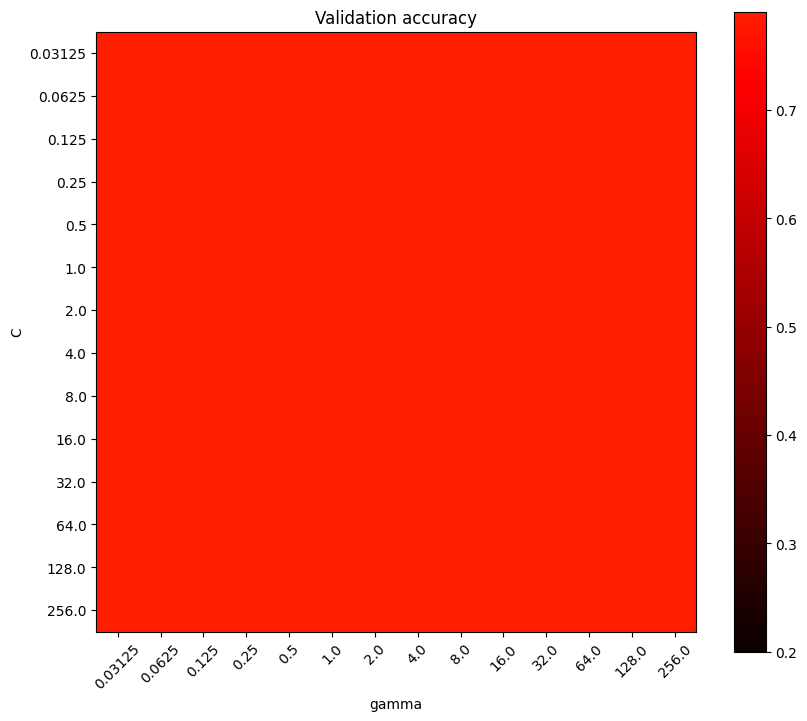

In [22]:
poly_grid = grid_search('poly', X_h_v_a, y_h_v_a)
print(poly_grid.best_params_)
print(poly_grid.best_score_)
plotSearchGrid(poly_grid)

{'C': 0.03125, 'gamma': 0.03125, 'kernel': 'rbf'}
0.5025974025974026


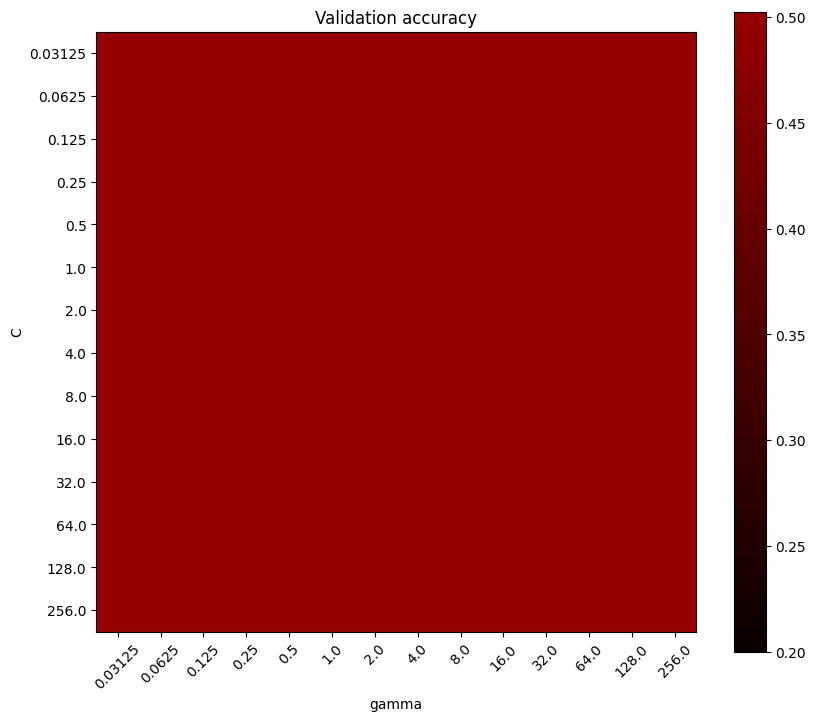

In [23]:
rbf_grid = grid_search('rbf', X_h_v_a, y_h_v_a)
print(rbf_grid.best_params_)
print(rbf_grid.best_score_)
plotSearchGrid(rbf_grid)

{'C': 0.03125, 'gamma': 0.03125, 'kernel': 'sigmoid'}
0.5025974025974026


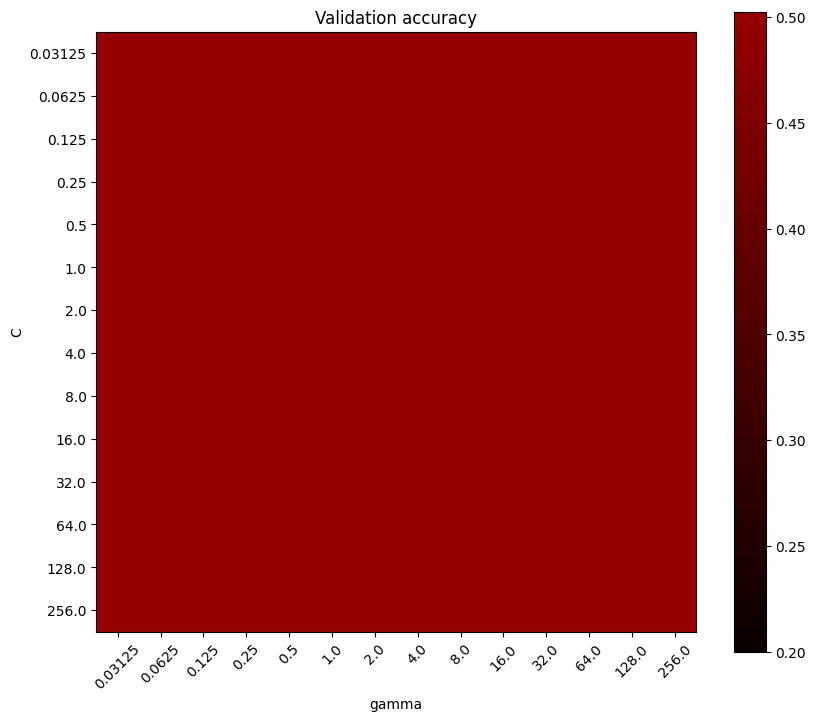

In [24]:
sigmoid_grid = grid_search('sigmoid', X_h_v_a, y_h_v_a)
print(sigmoid_grid.best_params_)
print(sigmoid_grid.best_score_)
plotSearchGrid(sigmoid_grid)

#### Results - Grid Search over 'C' and 'gamma' for linear, poly, radial bias function and sigmoid kernels
The Grid Searches over the parameters of C and gamma for the various kernels show again that linear and poly kernels can learn something on this data and can get slightly higher accuracies than the defaults. Again rbf and sigmoid do not learn.

Note however, that the plots show that C and gamma have very little affect. This is quite surprising and implies we might need to massage the data.

In the next set of experiments we repeat this grid searches, but normalize the data first. Here we normalize across all features.


#### Normalize data and repeat searches
Given the odd 'C' vs 'gamma' plots, we normalize the data and see if this plots are more reasonable

In [25]:
X_h_v_a_norm, y_h_v_a = extract_data(df, labels=['happy', 'angry'], normalization='norm')

file ./archive/audio_speech_actors_01-24/Actor_11/03-01-03-01-01-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_13/03-01-03-01-02-01-13.wav yeilds unexpected mfcc size, skipping


{'C': 256.0, 'gamma': 0.03125, 'kernel': 'linear'}
0.6490772385509228


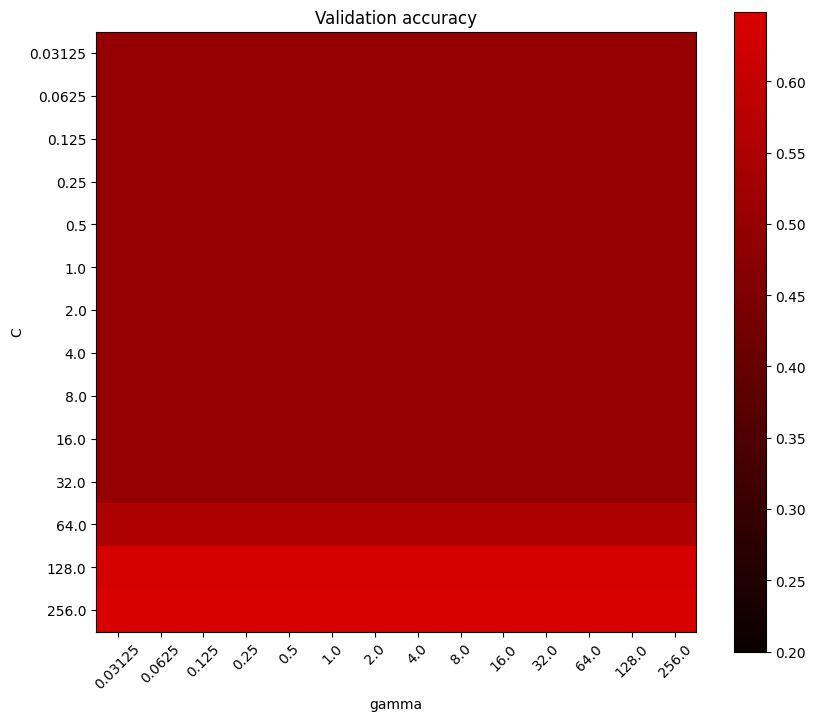

In [26]:
linear_grid = grid_search('linear', X_h_v_a_norm, y_h_v_a)
print(linear_grid.best_params_)
print(linear_grid.best_score_)
plotSearchGrid(linear_grid)

{'C': 8.0, 'gamma': 256.0, 'kernel': 'poly'}
0.8091250854408749


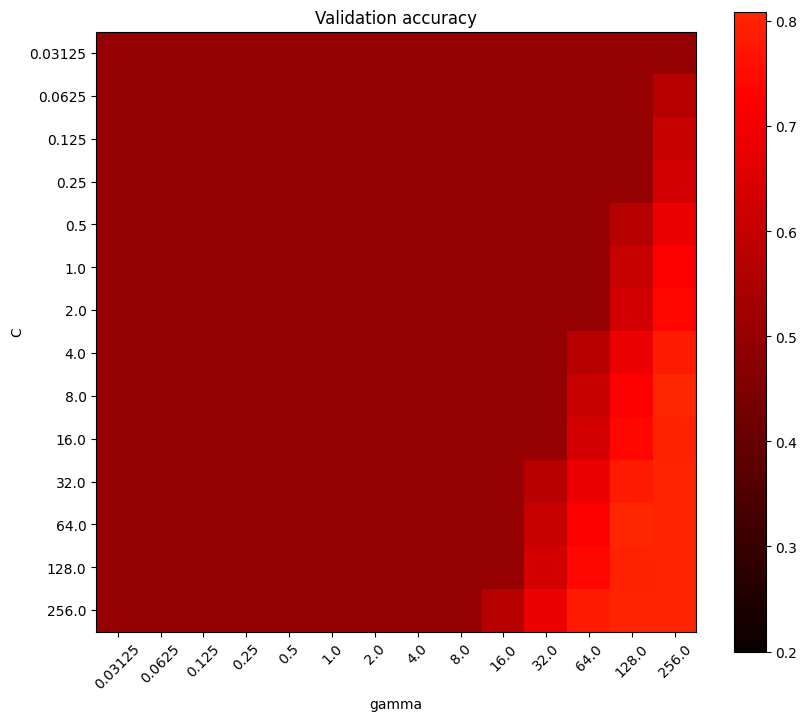

In [27]:
poly_grid = grid_search('poly', X_h_v_a_norm, y_h_v_a)
print(poly_grid.best_params_)
print(poly_grid.best_score_)
plotSearchGrid(poly_grid)

{'C': 16.0, 'gamma': 256.0, 'kernel': 'rbf'}
0.8012987012987013


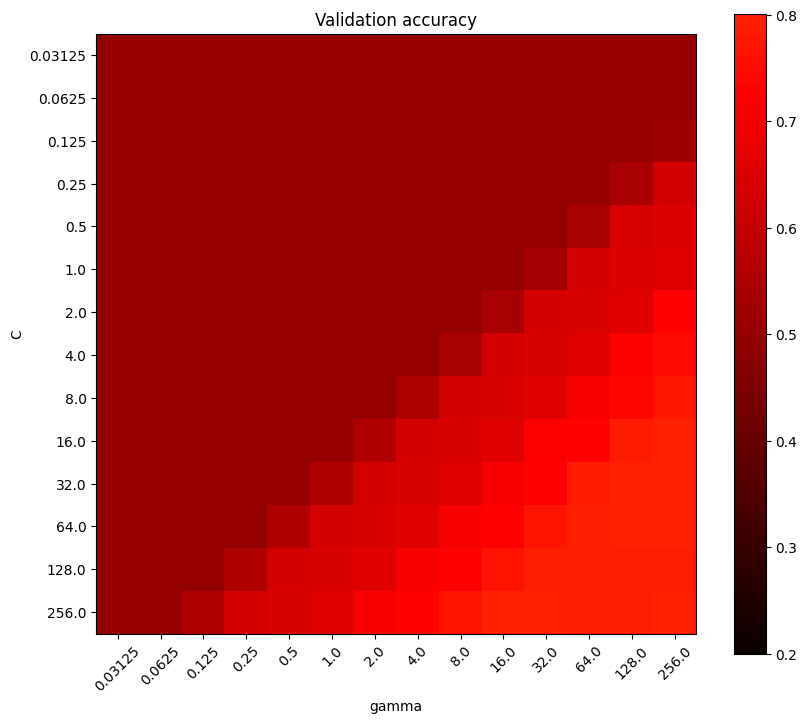

In [28]:
rbf_grid = grid_search('rbf', X_h_v_a_norm, y_h_v_a)
print(rbf_grid.best_params_)
print(rbf_grid.best_score_)
plotSearchGrid(rbf_grid)

{'C': 256.0, 'gamma': 32.0, 'kernel': 'sigmoid'}
0.8013328776486672


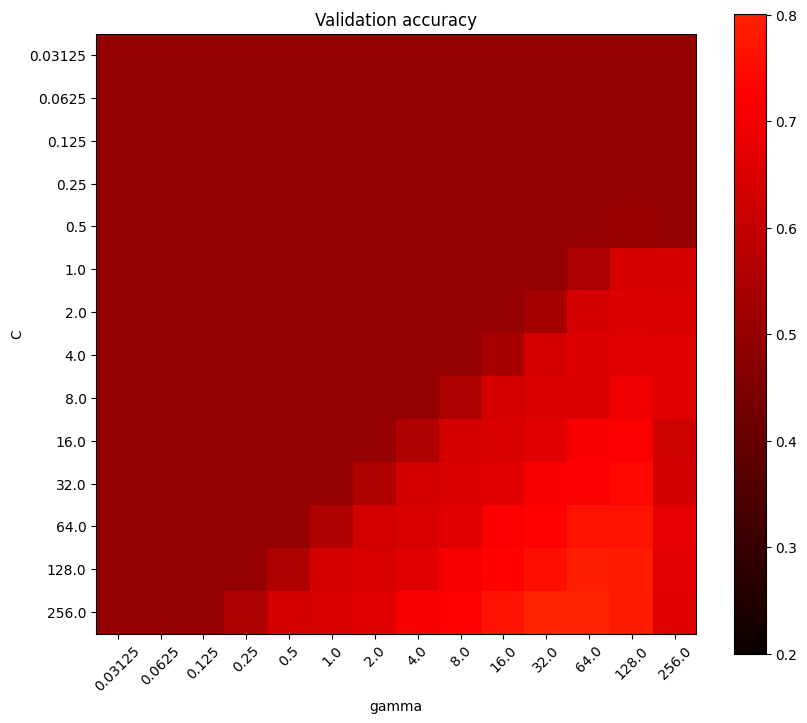

In [29]:
sigmoid_grid = grid_search('sigmoid', X_h_v_a_norm, y_h_v_a)
print(sigmoid_grid.best_params_)
print(sigmoid_grid.best_score_)
plotSearchGrid(sigmoid_grid)

#### Results - Normalize data and repeat searches
With normalized data, we see some interesting changes. With this data, while the linear kernel's performation is quite a bit worse, the poly kernel's results are slightly better AND the rbd and sigmoid kernels get nearly identical results to the poly kernel.

Again though, in the plot we see some strangeness. That is, while C and gamma now have an effect (except for linear, where gamma is not used), the effects take place a very high levels of C and gamma. This implies to me that these higher values or overcomming something in the normalized data.

Given these results, we try a different normalization. We normalize the data for each coefficient, rather than across all coefficients and repeat the experiments.

#### Normalize data by coefficient and repeat searches
Given above results, we normalize by coefficient, rather than across coefficients and repeat the searches

In [30]:
X_h_v_a_cnorm, y_h_v_a = extract_data(df, labels=['happy', 'angry'], normalization='coef')

file ./archive/audio_speech_actors_01-24/Actor_11/03-01-03-01-01-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_13/03-01-03-01-02-01-13.wav yeilds unexpected mfcc size, skipping


{'C': 8.0, 'gamma': 0.03125, 'kernel': 'linear'}
0.7958646616541354


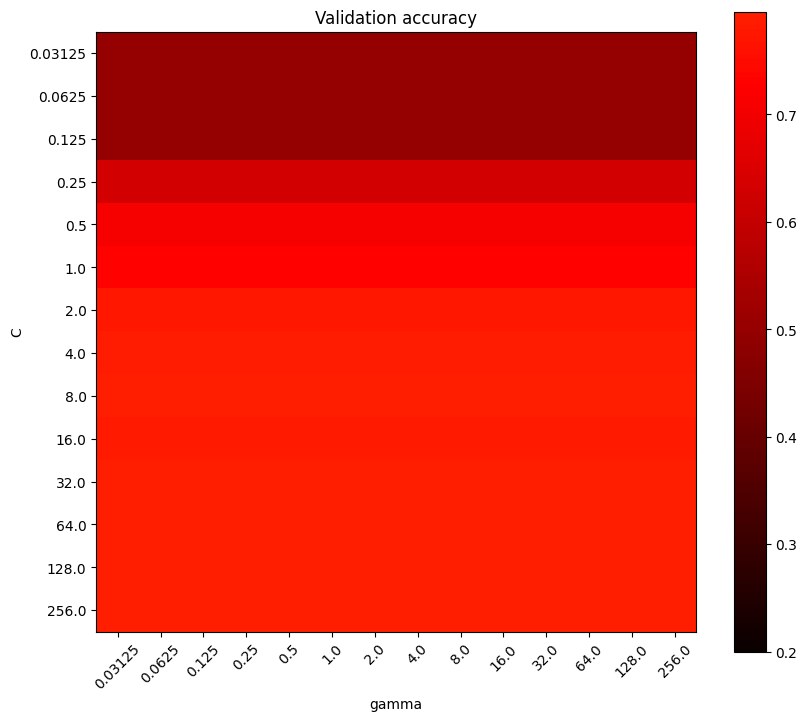

In [31]:
linear_grid = grid_search('linear', X_h_v_a_cnorm, y_h_v_a)
print(linear_grid.best_params_)
print(linear_grid.best_score_)
plotSearchGrid(linear_grid)

{'C': 0.03125, 'gamma': 16.0, 'kernel': 'poly'}
0.803691045796309


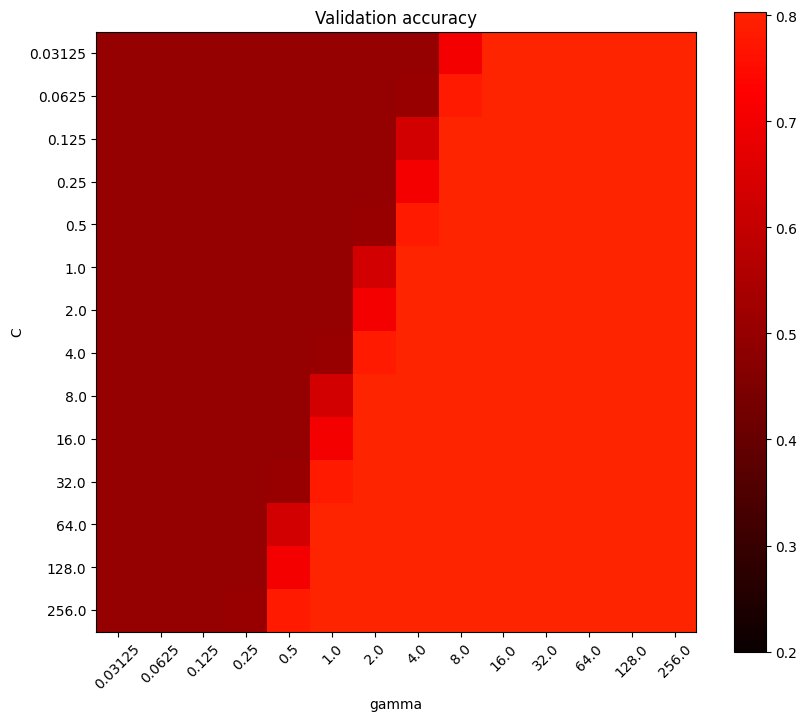

In [32]:
poly_grid = grid_search('poly', X_h_v_a_cnorm, y_h_v_a)
print(poly_grid.best_params_)
print(poly_grid.best_score_)
plotSearchGrid(poly_grid)

{'C': 4.0, 'gamma': 4.0, 'kernel': 'rbf'}
0.8272043745727956


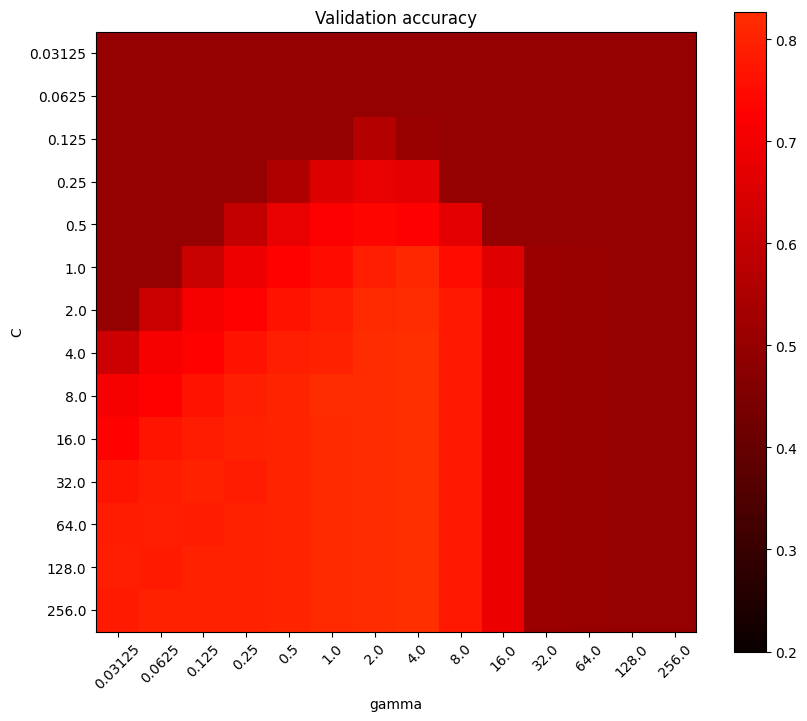

In [33]:
rbf_grid = grid_search('rbf', X_h_v_a_cnorm, y_h_v_a)
print(rbf_grid.best_params_)
print(rbf_grid.best_score_)
plotSearchGrid(rbf_grid)

{'C': 16.0, 'gamma': 0.5, 'kernel': 'sigmoid'}
0.7958646616541354


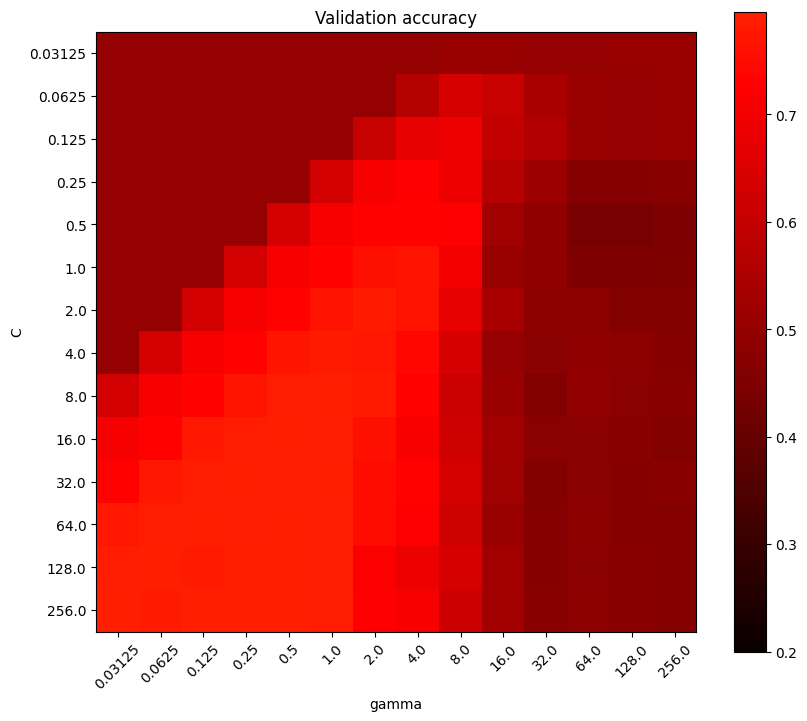

In [34]:
sigmoid_grid = grid_search('sigmoid', X_h_v_a_cnorm, y_h_v_a)
print(sigmoid_grid.best_params_)
print(sigmoid_grid.best_score_)
plotSearchGrid(sigmoid_grid)

#### Results - Normalize data by coefficient and repeat searches
With the change to normalization by coefficient, we see marked improvement.
First, performance with linear kernel recovers to 79.6% accuracy.
Second, the effect of C and gamma occur at much lower values and don't cluster around the very high values.

In this experiment, rbf gets the best results, although one a few percent higher than any of the other kernels.

With these results, we'll try applying the rbf kernel on two more examples of two arbitraily picked emotion pairs, with by coefficient normalization. We'll try the pairs 'happy', 'fearful' and 'calm', 'angry'

#### Additional Pairs
We now compare grid searches on two additional pairs of emotions - 'happy', 'fearful' and 'calm', 'angry' to see if the results hold up across other emotion examples.

In [35]:
#let's try another pair
X_h_v_a_cnorm, y_h_v_a = extract_data(df, labels=['happy', 'fearful'], normalization='coef')

file ./archive/audio_speech_actors_01-24/Actor_11/03-01-06-02-02-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-03-01-01-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-06-02-02-02-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_05/03-01-06-01-02-02-05.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_05/03-01-06-01-01-01-05.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_05/03-01-06-01-02-01-05.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_05/03-01-06-02-02-02-05.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_23/03-01-06-01-02-01-23.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_23/03-01-06-01-02-02-23.wav yeilds unexpected mfc

{'C': 2.0, 'gamma': 8.0, 'kernel': 'rbf'}
0.6927927927927928


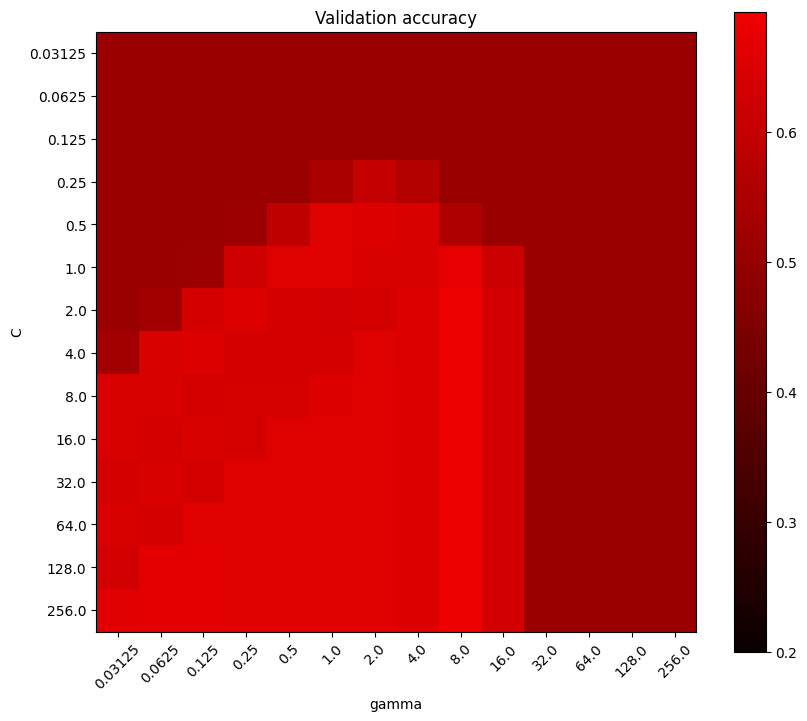

In [36]:
rbf_grid = grid_search('rbf', X_h_v_a_cnorm, y_h_v_a)
print(rbf_grid.best_params_)
print(rbf_grid.best_score_)
plotSearchGrid(rbf_grid)

In [37]:
#let's try another pair
X_h_v_a_cnorm, y_h_v_a = extract_data(df, labels=['calm', 'angry'], normalization='coef')

file ./archive/audio_speech_actors_01-24/Actor_13/03-01-02-02-01-01-13.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_13/03-01-02-01-02-01-13.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_13/03-01-02-02-02-02-13.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_13/03-01-02-01-02-02-13.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_13/03-01-02-02-02-01-13.wav yeilds unexpected mfcc size, skipping


{'C': 2.0, 'gamma': 4.0, 'kernel': 'rbf'}
0.8997543859649122


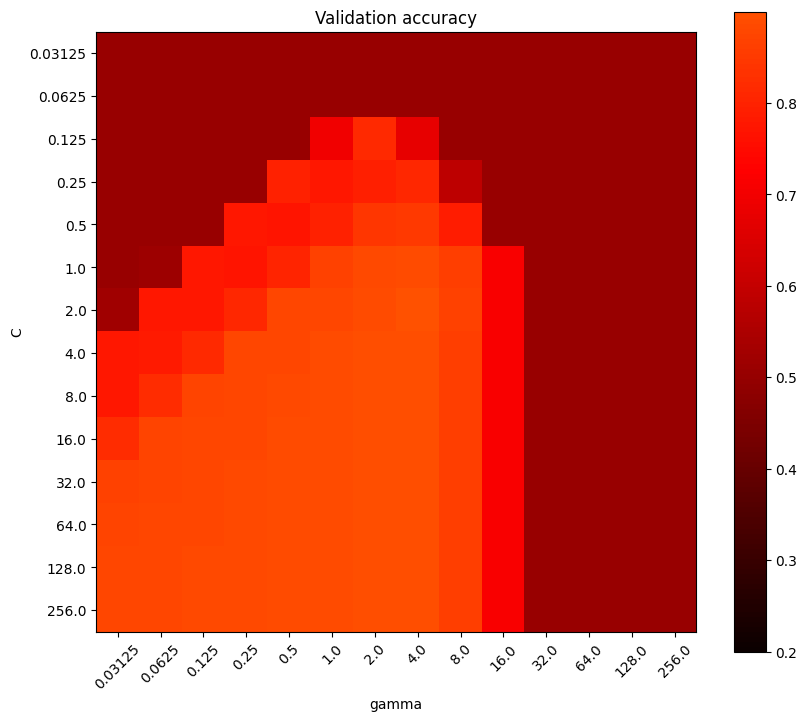

In [38]:
rbf_grid = grid_search('rbf', X_h_v_a_cnorm, y_h_v_a)
print(rbf_grid.best_params_)
print(rbf_grid.best_score_)
plotSearchGrid(rbf_grid)

#### Results - Additional Pairs
In these two addtional pairs, the SVM is able to learn to distinguish the two emotions, although it has a much harder time with the pair 'happy','fearful' than it does with the pair 'calm','angry'

Both plots for C vs gamma have similar shape, althought slightly different optimal values for the two cases.

This is promising.

#### Multi-class SVM on complete set of emotions
Given that it seems we are able to distinguish two emotions, and although we did not visit multi-class SVM in the class, let's still see if, given the rbf kernel with normalization by coefficient, we can learn to distinguish all the emotions present in the data.

Since we are comparing multiple classes, a confusion matrix would be useful to understand the results. Therefore, eventhough in training we are doing cross validation, we will first split the data into a train and test set, so we can construct the confusion matrix against test data that will not have been seen during training.

In [39]:
X_multi_coef, y_multi = extract_data(df, labels=['neutral','calm','happy','sad','angry','fearful','disgust','surprised'], binary_class=False,
                                     normalization='coef')

X_train_multi_coef, X_val_multi_coef, y_train_multi, y_val_multi = train_test_split(X_multi_coef, y_multi, test_size=0.25, random_state=42)

print(X_train_multi_coef.shape)
print(y_train_multi.shape)
print(X_val_multi_coef.shape)
print(y_val_multi.shape)

file ./archive/audio_speech_actors_01-24/Actor_11/03-01-08-01-01-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-08-02-02-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-06-02-02-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-08-01-02-02-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-08-02-01-02-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-01-01-01-01-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-08-02-02-02-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-08-01-01-02-11.wav yeilds unexpected mfcc size, skipping
file ./archive/audio_speech_actors_01-24/Actor_11/03-01-03-01-01-01-11.wav yeilds unexpected mfc

{'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}
0.5405149236728185


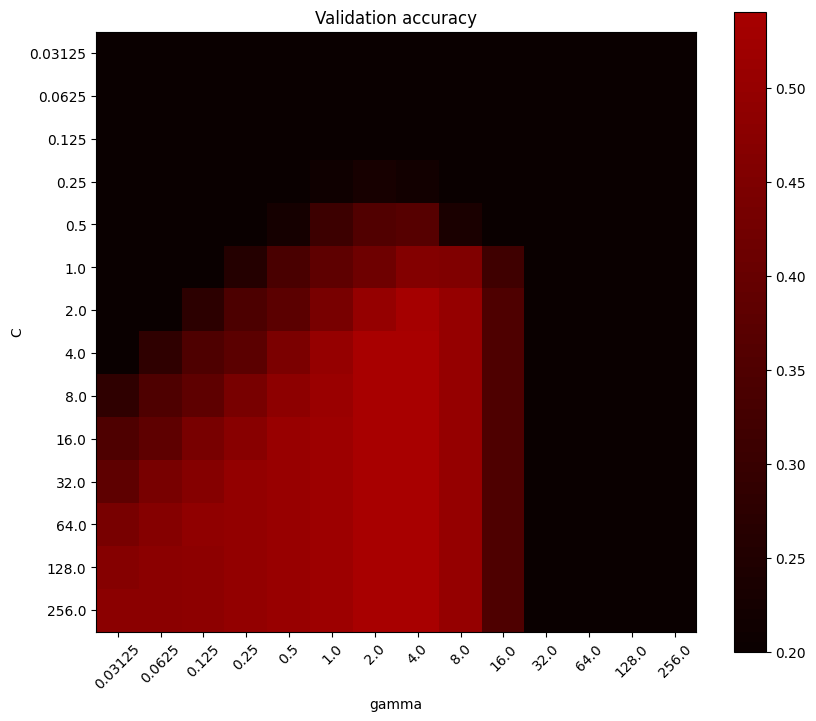

In [40]:
rbf_grid = grid_search('rbf', X_train_multi_coef, y_train_multi)
print(rbf_grid.best_params_)
print(rbf_grid.best_score_)
plotSearchGrid(rbf_grid)

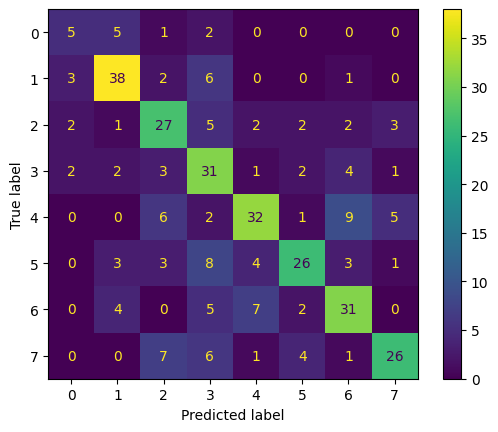

In [41]:
val_yhat = rbf_grid.best_estimator_.predict(X_val_multi_coef)
confm = confusion_matrix(y_val_multi, val_yhat, labels=[1,2,3,4,5,6,7,8])
confm_disp = ConfusionMatrixDisplay(confm).plot()

#### Results - Multi-class SVM on complete set of emotions
Clearly we are able to do multiclass prediction of emotion from sound files with an SVM!
While accuracy is modest, the confusion matrix has a clear diagonal small numbers of misclassifications.

## Conclusions
We set out to answser the question, "Can we use a SVM to identify emotion in audio recordings in a small data regime?"
The answer to this question is "Yes, Yes we can".

Through our experiments we learned and have shown that we can take a raw audio recording, transform it to mel-frequency cepstral coefficients (mfcc) representation, and build an SVM classifier.

Only small modifications to the data were necessary. That is, trimming the data to remove silence in the leading and trailing edge of the recording and normalizing the data on a per coefficient basis. With these small changes we first showed that binary classification between two emotions was possible, ranging from ~69% to 90% accuracy depending on which emotion pairs were attempted. And that values of C and gamma were reasonable. We then went on to show that it is possible to use perform multiclass classification with a SVM for all the emotions present in the dataset. This is encouraging especially given the limitations the SVM has, consuming a 1D flattened array of features per data sample, since we lose the temporal information one would expect would be helpful.

The obvious question is could we do better? What would we change to improve. The next most obvious step would be feature engineering. That is, to compute other features from the data that would make the resulting representation more suitable to the SVM algorithm. And this in fact highlights the difference between this approach and the deep learning approach that would be preferred today. Here we would have to rely on own knowledge of speech to craft new features whereas a deep learning approach has the benefit of learning the features best suited to the job.

In the case here, with the RAVDESS dataset, there is doubtless too little data to support a deep learning approach, whereas the SVM was able to do a reasonable job. Hence if we find ourselves in a low data regime, we can try this approach and if we have sufficent data, apply a deep learning approach


